## Astronomy 406 "Computational Astrophysics" (Fall 2017)

### Week 10: Markov Chain Monte Carlo (continued) and Monte Carlo integration

<b>Reading:</b> notes below, as well as [$\S$15.8](https://umich.instructure.com/files/5261919/download?download_frd=1), [$\S$7.7-7.9](https://umich.instructure.com/files/5261918/download?download_frd=1) of [Numerical Recipes](http://numerical.recipes/), and $\S$5.8 of [Machine Learning](http://www.astroml.org/).

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
import emcee
import corner

#### Exercise with a multi-variate Gaussian function

Let's do an idealized test with a 10-parameter Gaussian with non-zero correlation - a fairly typical posterior for well-constrained parameters. It is an example from [emcee quickstart page](http://dfm.io/emcee/current/user/quickstart/).

The likelihood is given by
$$
    {\cal L}(\mathbf{x}) \propto \frac{1}{\mathrm{det}(\mathbf{\Sigma})^{1/2}} \;
    \exp\left( -\frac{1}{2} (\mathbf{x}-\boldsymbol\mu)^T \mathbf{\Sigma}^{-1} (\mathbf{x}-\boldsymbol\mu) \right)
$$

In [2]:
ndim = 10

mu = np.zeros(ndim)
mu[0] = 1.0
mu[1] = 2.0

cov = np.zeros((ndim, ndim))
for i in range(ndim):
    cov[i,i] = 1.
cov[0,1] = cov[1,0] = 0.99

# calculate inverse covariance matrix
icov = np.linalg.inv(cov)

def lnLikelihood(p, mu, icov):
    diff = p-mu
    det_cov = np.linalg.det(np.linalg.inv(icov))
    return -0.5 * (np.dot(diff,np.dot(icov,diff)) + np.log(det_cov))

def lnPrior(p):
    if not (-10 < p.any() < 10):
        return -np.inf
    return 0.0

def lnPosterior(p, mu, icov):
    return lnPrior(p) + lnLikelihood(p, mu, icov)

In [3]:
nwalkers = 100
ncorr = 1
nsteps = 1000
nburn = 20 * 200 #20*ncorr

# Choose an initial set of positions for the walkers
pos = [np.random.rand(ndim) for i in xrange(nwalkers)]

# Initialize the sampler with the chosen specs
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnPosterior, args=[mu, icov])

# Run burn-in steps
pos, prob, state = sampler.run_mcmc(pos, nburn)

# Reset the chain to remove the burn-in samples
sampler.reset()

converged = False
nchain = nburn

while not converged:
    pos, prob, state = sampler.run_mcmc(pos, nsteps, rstate0=state)
    nchain += nsteps
    
    r, p = stats.pearsonr(sampler.flatchain[:,0], sampler.flatchain[:,1])

    print "p[0] = {0:.3f} +- {1:.3f}  p[1] = {2:.3f} +- {3:.3f}  r = {4:.3f}  nchain = {5:d}"\
      .format(np.mean(sampler.flatchain[::ncorr,0]), np.std(sampler.flatchain[::ncorr,0]),\
       np.mean(sampler.flatchain[::ncorr,1]), np.std(sampler.flatchain[::ncorr,1]), r, nchain)
    
    converged = (nchain > 10000)
    
# Print out the mean acceptance fraction among all walkers
print "Mean acceptance fraction = %.3f" % np.mean(sampler.acceptance_fraction)

p[0] = 0.996 +- 1.011  p[1] = 1.994 +- 1.014  r = 0.990  nchain = 5000
p[0] = 0.990 +- 1.001  p[1] = 1.988 +- 1.001  r = 0.990  nchain = 6000
p[0] = 0.991 +- 0.995  p[1] = 1.990 +- 0.996  r = 0.990  nchain = 7000
p[0] = 0.987 +- 0.995  p[1] = 1.985 +- 0.995  r = 0.990  nchain = 8000
p[0] = 0.997 +- 0.999  p[1] = 1.993 +- 0.997  r = 0.990  nchain = 9000
p[0] = 0.992 +- 1.001  p[1] = 1.990 +- 1.000  r = 0.990  nchain = 10000
p[0] = 0.995 +- 1.003  p[1] = 1.993 +- 1.002  r = 0.990  nchain = 11000
Mean acceptance fraction = 0.418


In [4]:
ncorr = int(np.max(sampler.get_autocorr_time(c=4)))
print ncorr

166


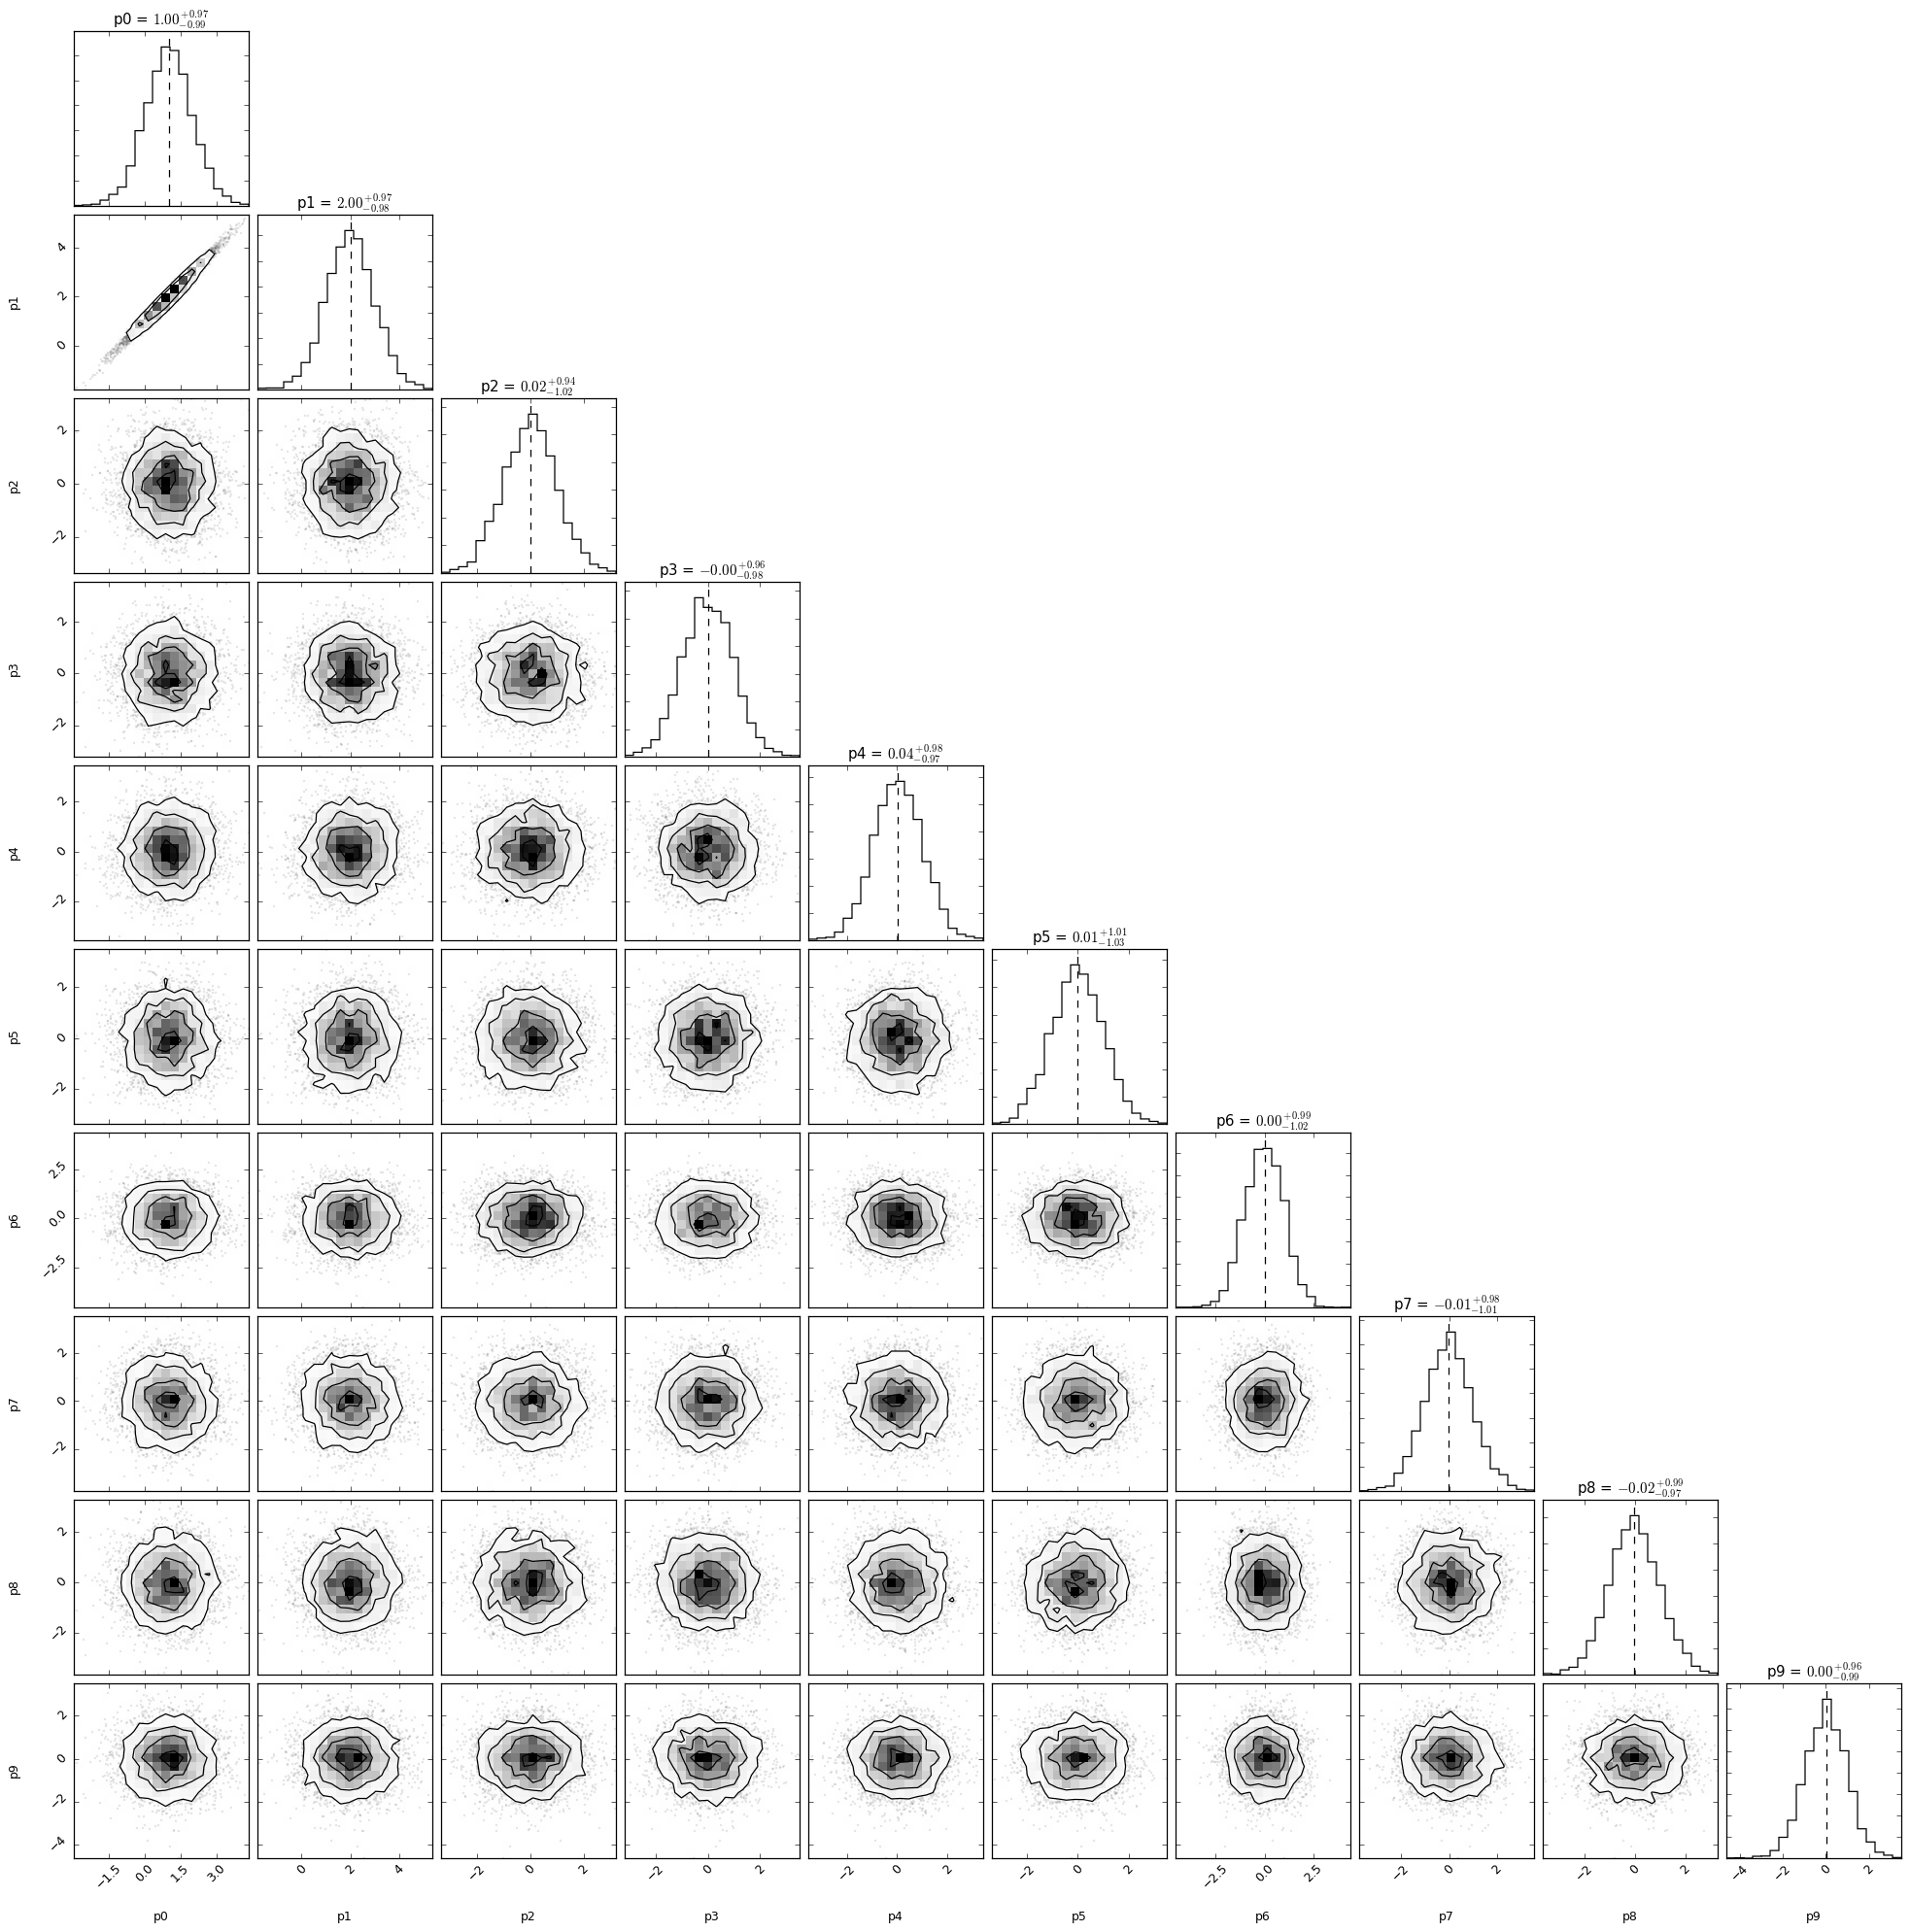

In [5]:
corner.corner(sampler.flatchain[::ncorr], labels=['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9'],\
              quantiles=[0.5], show_titles=True)
plt.show()

Now let's try direct maximization of the likelihood.

In [6]:
def neglnLikelihood(p, mu, icov):
    return -lnLikelihood(p, mu, icov)

o = optimize.minimize(neglnLikelihood, np.random.rand(ndim), args=(mu, icov))

print "p[0] = {0:.3f} +- {1:.3f}  p[1] = {2:.3f} +- {3:.3f}  r = {4:.3f}"\
      .format(o.x[0], np.sqrt(o.hess_inv[0,0]),\
       o.x[1], np.sqrt(o.hess_inv[1,1]), o.hess_inv[0,1])

p[0] = 1.000 +- 0.996  p[1] = 2.000 +- 0.996  r = 0.982


Amazingly, SciPy can minimize a function of even 10 parameters, with good success.

### Monte Carlo Integration

Pick $N$ random points $x_i$, uniformly distributed in a multidimensional volume $V$. The basic theorem of Monte Carlo integration estimates the integral of a function $f$ over the multidimensional volume as

$$ \int f(\mathbf{x}) dV \approx V \langle f\rangle \pm V \sqrt{\langle f^2\rangle - \langle f\rangle^2 \over N}, $$

where

$$ \langle f\rangle \equiv {1\over N} \sum\limits_{i=0}^{N-1} f(x_i). $$

It is implemented in a simple routine below.

In [7]:
def simple_mcintegration(integrand, xmin, xmax, ndim, n):
    f, f2 = 0., 0.
    x = np.zeros(ndim)
    # integration volume
    volume = 1.
    for j in range(ndim):
        volume *= (xmax[j]-xmin[j])
    # calculate mean f and f^2
    for i in range(n):
        for j in range(ndim):
            x[j] = np.random.uniform(xmin[j], xmax[j])
        s = integrand(x)
        f += s
        f2 += s**2
    f = f/n
    f2 = f2/n
    # calculate the value of integral and estimated error
    result = volume*f
    error = volume*np.sqrt((f2-f**2)/n)
    return result, error

Let's try it on a very simple example - integration of the volume of a 3D sphere.

In [8]:
def integrand(x):
    r = x[0]**2 + x[1]**2 + x[2]**2
    if r <= 1.:
        return 3./4./np.pi   #This is to get integral equal to 1 as check
    else:
        return 0.

ndim = 3
xmin = -1.*np.ones(ndim)
xmax = 1.*np.ones(ndim)
expected = 1.

for n in [1000, 10000, 100000, 1000000]:
    result, error = simple_mcintegration(integrand, xmin, xmax, ndim, n)
    
    print "n = %7d  Int = %.4f  estimated error = %.4f  actual error = %.4f"\
        % (n, result, error, abs(result-expected))

n =    1000  Int = 0.9912  estimated error = 0.0302  actual error = 0.0088
n =   10000  Int = 1.0061  estimated error = 0.0095  actual error = 0.0061
n =  100000  Int = 1.0015  estimated error = 0.0030  actual error = 0.0015
n = 1000000  Int = 1.0001  estimated error = 0.0010  actual error = 0.0001


Now we take a more difficult case - integration over a thin shell.

In [9]:
#Integrating a "balloon function"

def integrand(x):
    r2 = x[0]**2 + x[1]**2 + x[2]**2
    d = 0.999
    d2 = d**2
    if d2 <= r2 and r2 <= 1.:
        return 3./4./np.pi/(1-d**3)
    else:
        return 0.

for n in [1000, 10000, 100000, 1000000]:
    result, error = simple_mcintegration(integrand, xmin, xmax, ndim, n)
    
    print "n = %7d  Int = %.4f  estimated error = %.4f  actual error = %.4f"\
        % (n, result, error, abs(result-expected))

n =    1000  Int = 0.6373  estimated error = 0.6369  actual error = 0.3627
n =   10000  Int = 1.3382  estimated error = 0.2917  actual error = 0.3382
n =  100000  Int = 1.0770  estimated error = 0.0828  actual error = 0.0770
n = 1000000  Int = 0.9960  estimated error = 0.0252  actual error = 0.0040


Integration over a spherical volume can be done more efficiently in spherical coordinates:

$$ \int dV = \int\limits_{0}^{r} dr \int\limits_{0}^{\pi} d\theta \int\limits_{0}^{2\pi} d\phi $$

<b>Exercise 2:</b> change integration variables to spherical coordinates and compare the integration accuracy with the previous case of Cartesian coordinates.

In [10]:
def integrand(x):
    r = x[0]
    theta = x[1]
    phi = x[2]
    if r <= 1. and theta < np.pi:
        return r**2*np.sin(theta)/(4./3.*np.pi)
    else:
        return 0.

ndim = 3
xmin = [ 0., 0., 0. ]
xmax = [ 1.5, np.pi, 2.*np.pi ]
expected = 1.

for n in [1000, 10000, 100000, 1000000]:
    result, error = simple_mcintegration(integrand, xmin, xmax, ndim, n)
    
    print "n = %7d  Int = %.4f  estimated error = %.4f  actual error = %.4f"\
        % (n, result, error, abs(result-expected))

n =    1000  Int = 1.0050  estimated error = 0.0474  actual error = 0.0050
n =   10000  Int = 1.0097  estimated error = 0.0155  actual error = 0.0097
n =  100000  Int = 0.9973  estimated error = 0.0048  actual error = 0.0027
n = 1000000  Int = 0.9975  estimated error = 0.0015  actual error = 0.0025


In [11]:
def integrand(x):
    r = x[0]
    theta = x[1]
    phi = x[2]
    if r <= 1. and np.pi/3. < theta and theta < np.pi*2./3. and phi < 2.*np.pi:
        return r**2*np.sin(theta)/(4*np.pi/3.)
    else:
        return 0.

ndim = 3
xmin = [ 0., 0., 0. ]
xmax = [ 1.0, np.pi, 2.*np.pi ]
expected = 1.

for n in [1000, 10000, 100000, 1000000]:
    result, error = simple_mcintegration(integrand, xmin, xmax, ndim, n)
    
    print "n = %7d  Int = %.4f  estimated error = %.4f  actual error = %.4f"\
        % (n, result, error, abs(result-expected))

n =    1000  Int = 0.4781  estimated error = 0.0321  actual error = 0.5219
n =   10000  Int = 0.5021  estimated error = 0.0105  actual error = 0.4979
n =  100000  Int = 0.4975  estimated error = 0.0033  actual error = 0.5025
n = 1000000  Int = 0.4998  estimated error = 0.0010  actual error = 0.5002


Read on more efficient sampling techniques in [$\S$7.9](https://umich.instructure.com/files/715726/download) of [Numerical Recipes](http://numerical.recipes/).